In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn import model_selection
import torch
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import (
    resnet50, ResNet50_Weights, 
    vit_b_16, ViT_B_16_Weights)
import matplotlib.pyplot as plt
import tikzplotlib
import seaborn as sns
sns.set_theme()
sns.set_context("paper")
sns.set_style("ticks")
from netcal.presentation import ReliabilityDiagram

from calibrators import fit_scaling_model, fit_binary_method, Temperature, Vector, Dirichlet
from evaluation import ECE_calc, metrics_from_logits_labels, eval_binary_method
from utils import logits_labels_from_dataloader, LogitsDataset

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)

path_dataset = Path('imagenet')

# Load model and data

In [2]:
model_name = 'ResNet-50'

models_and_weights_torchvision = {
    'ResNet-50': (resnet50, ResNet50_Weights.DEFAULT),
    'ViT-B/16': (vit_b_16, ViT_B_16_Weights.DEFAULT),
}

architecture, weights = models_and_weights_torchvision[model_name]
classifier = architecture(weights=weights).eval().cuda()
transforms = weights.transforms()
num_classes = 1000
num_epochs = 200

In [3]:
valid_size = 25000
batch_size = 64
dataset_val = ImageFolder(path_dataset/'val', transform=transforms)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
# separate into validation (calibration) and test sets
test_indices, valid_indices = model_selection.train_test_split(np.arange(len(dataset_val)),
                                                                        train_size=len(dataset_val) - valid_size,
                                                                        stratify=dataset_val.targets,
                                                                        random_state=seed)
valid_loader = DataLoader(dataset_val, pin_memory=True, batch_size=batch_size,
                        sampler=SubsetRandomSampler(valid_indices), num_workers=4)
test_loader = DataLoader(dataset_val, pin_memory=True, batch_size=batch_size,
                        sampler=SubsetRandomSampler(test_indices), num_workers=4)

# Create calibration data
logits_val, labels_val = logits_labels_from_dataloader(classifier, valid_loader)
logits_test, labels_test = logits_labels_from_dataloader(classifier, test_loader)
dataset_logits_val = LogitsDataset(logits_val, labels_val)
dataloader_logits_val = DataLoader(dataset_logits_val, batch_size=512)

# Reliability diagrams

Uncalibrated


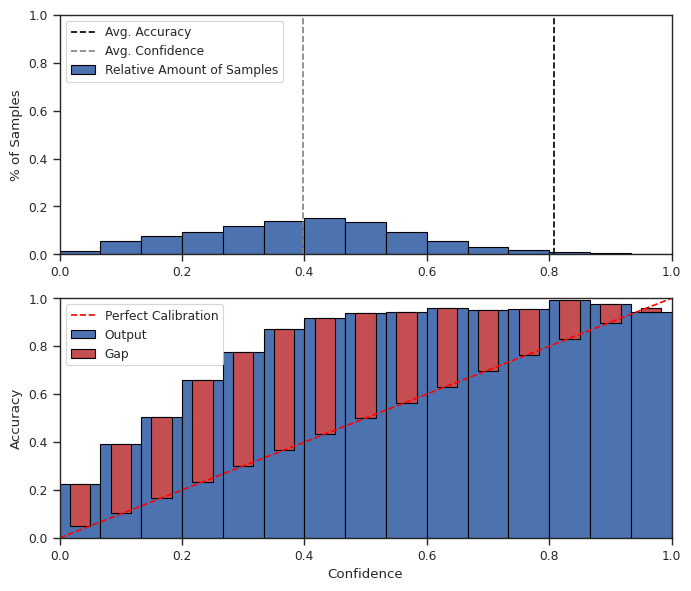

TS


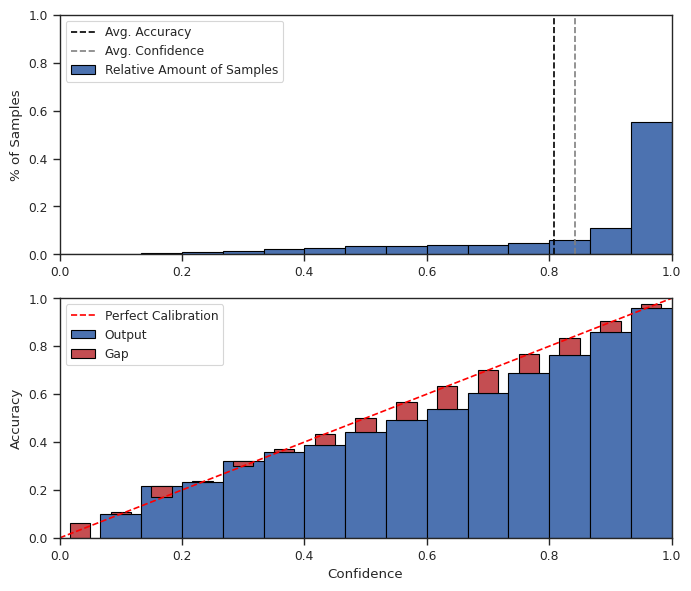

TS_tva


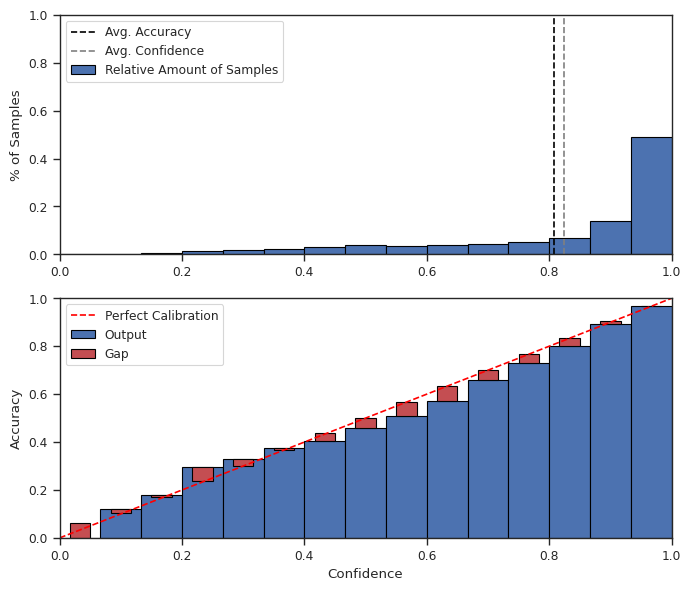

HB_tva


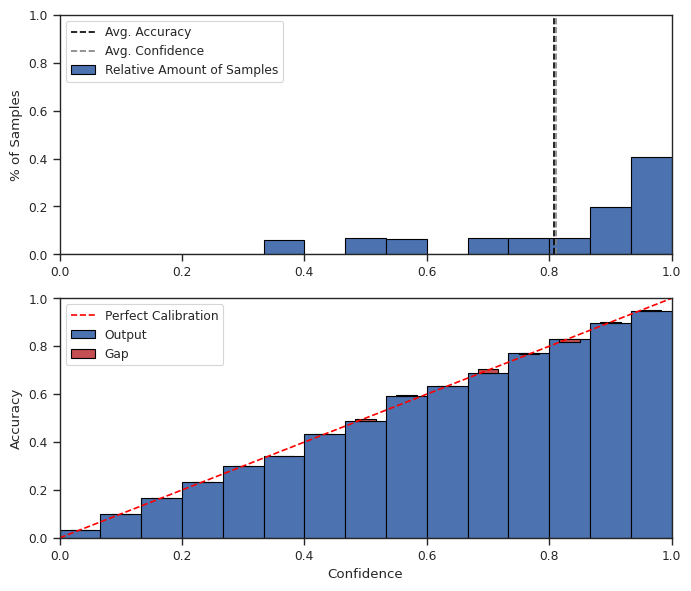

In [4]:
# figure 1
probs = torch.softmax(logits_test, axis=1).numpy()
ground_truth = labels_test.numpy()

print('Uncalibrated')
diagram = ReliabilityDiagram(bins=15)
diagram.plot(probs, ground_truth)
plt.show()


# figure 2
if model_name == 'ResNet-50':
    model = fit_scaling_model('temperature', dataloader_logits_val, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    logits_scaled = model(logits_test.cuda()).detach().cpu()
    probs_scaled_TS = torch.softmax(logits_scaled, axis=1).numpy()

    print('TS')
    diagram = ReliabilityDiagram(bins=15)
    diagram.plot(probs_scaled_TS, ground_truth)
    plt.show()

elif model_name == 'ViT-B/16':
    model = fit_scaling_model('vector', dataloader_logits_val, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    logits_scaled = model(logits_test.cuda()).detach().cpu()
    probs_scaled_VS = torch.softmax(logits_scaled, axis=1).numpy()

    print('VS')
    diagram = ReliabilityDiagram(bins=15)
    diagram.plot(probs_scaled_VS, ground_truth)
    plt.show()


# figure 3
if model_name == 'ResNet-50':
    model = fit_scaling_model('temperature', dataloader_logits_val, num_classes, binary_loss=True, regularization=False, num_epochs=num_epochs)
    logits_scaled = model(logits_test.cuda()).detach().cpu()
    probs_scaled_TStva = torch.softmax(logits_scaled, axis=1).numpy()

    print('TS_tva')
    diagram = ReliabilityDiagram(bins=15)
    diagram.plot(probs_scaled_TStva, ground_truth)
    plt.show()

elif model_name == 'ViT-B/16':
    model = fit_scaling_model('vector', dataloader_logits_val, num_classes, binary_loss=True, regularization=True, num_epochs=num_epochs)
    logits_scaled = model(logits_test.cuda()).detach().cpu()
    probs_scaled_VSregtva = torch.softmax(logits_scaled, axis=1).numpy()

    print('VS_reg_tva')
    diagram = ReliabilityDiagram(bins=15)
    diagram.plot(probs_scaled_VSregtva, ground_truth)
    plt.show()


# figure 4
probs = torch.softmax(logits_val, axis=1)
certainties, y_pred = probs.max(axis=1)
correct = y_pred == labels_val
model = fit_binary_method('HB_tva_eqmass', logits_val, labels_val, num_classes)
probs = torch.softmax(logits_test, axis=1)
certainties_test, y_pred = probs.max(axis=1)
certainties_scaled = model.transform(certainties_test.cpu().numpy())
correct = (y_pred == labels_test).numpy()

print('HB_tva')
diagram = ReliabilityDiagram(bins=15)
diagram.plot(certainties_scaled, correct)
plt.show();

# Regularization

Text(0, 0.5, 'ECE test [%]')

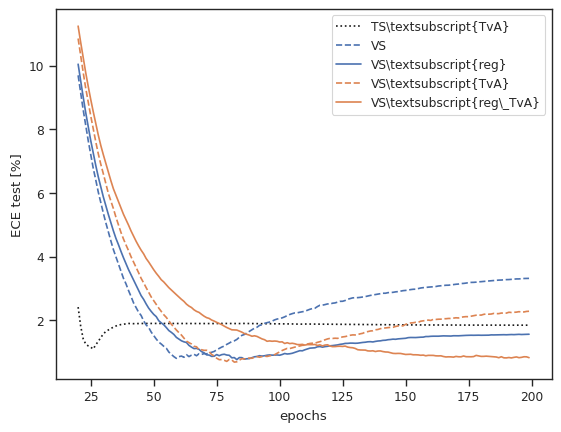

In [5]:
def compute_ECE(model):
    with torch.no_grad():
        logits_scaled = model(logits_val.cuda()).cpu()
    probs_scaled_VS = torch.softmax(logits_scaled, axis=1)
    certainties, y_pred = probs_scaled_VS.max(axis=1)
    correct = (y_pred == labels_val)
    samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)
    ece_train = ECE_calc(samples_certainties).item()
        
    with torch.no_grad():
        logits_scaled = model(logits_test.cuda()).cpu()
    probs_scaled_VS = torch.softmax(logits_scaled, axis=1)
    certainties, y_pred = probs_scaled_VS.max(axis=1)
    correct = (y_pred == labels_test)
    samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)
    ece_test = ECE_calc(samples_certainties).item()
    
    return ece_train, ece_test


def fit_scaling_model_log(method, dataloader_logits_calib, num_classes, binary_loss, regularization, temperature_ref=1, num_epochs=200):
    
    if method == 'temperature':
        calibrator = Temperature().cuda()
    elif method =='vector':
        calibrator = Vector(num_classes, temperature_ref).cuda()
    elif method == 'dirichlet':
        calibrator = Dirichlet(num_classes, temperature_ref).cuda()
    else:
        raise ValueError('Unknown method')

    optimizer = torch.optim.Adam(calibrator.parameters(), lr=0.001)

    ECE_train = np.zeros(num_epochs)
    ECE_test = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, y in dataloader_logits_calib:
            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            logits_scaled = calibrator(x)
            if binary_loss:
                probas = torch.softmax(logits_scaled, axis=1)
                confidence, y_pred = torch.max(probas, axis=1)
                correct = (y_pred == y).float()
                loss = nn.functional.binary_cross_entropy(confidence, correct)
            else:
                loss = nn.functional.cross_entropy(logits_scaled, y)
            if method == 'dirichlet':
                loss += calibrator.off_diag_reg * calibrator.model[0].weight.clone().fill_diagonal_(0).square().sum()
                loss += calibrator.bias_reg * calibrator.model[0].bias.square().sum()
                if regularization:
                    loss += calibrator.diag_reg * (torch.diagonal(calibrator.model[0].weight) - 1).square().mean()
            elif method == 'vector' and regularization:
                loss += calibrator.vec_reg * (calibrator.vec - 1).square().mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        ECE_train[epoch], ECE_test[epoch] = compute_ECE(calibrator)
    
    return ECE_test


ECE_test = {}
ECE_test['TS_tva'] = fit_scaling_model_log('temperature', dataloader_logits_val, num_classes, binary_loss=True, regularization=False)
ECE_test['VS'] = fit_scaling_model_log('vector', dataloader_logits_val, num_classes, binary_loss=False, regularization=False)
ECE_test['VS_reg'] = fit_scaling_model_log('vector', dataloader_logits_val, num_classes, binary_loss=False, regularization=True)
ECE_test['VS_tva'] = fit_scaling_model_log('vector', dataloader_logits_val, num_classes, binary_loss=True, regularization=False)
ECE_test['VS_reg_tva'] = fit_scaling_model_log('vector', dataloader_logits_val, num_classes, binary_loss=True, regularization=True)


plt.figure()
epoch_start = 20
plt.plot(np.arange(epoch_start, len(ECE_test['TS_tva'])), 100*ECE_test['TS_tva'][epoch_start:], c='k', ls=':', label=r'TS\textsubscript{TvA}')
plt.plot(np.arange(epoch_start, len(ECE_test['VS'])), 100*ECE_test['VS'][epoch_start:], c='C0', ls='--', label='VS')
plt.plot(np.arange(epoch_start, len(ECE_test['VS_reg'])), 100*ECE_test['VS_reg'][epoch_start:], c='C0', ls='-', label=r'VS\textsubscript{reg}')
plt.plot(np.arange(epoch_start, len(ECE_test['VS_tva'])), 100*ECE_test['VS_tva'][epoch_start:], c='C1', ls='--', label=r'VS\textsubscript{TvA}')
plt.plot(np.arange(epoch_start, len(ECE_test['VS_reg_tva'])), 100*ECE_test['VS_reg_tva'][epoch_start:], c='C1', ls='-', label=r'VS\textsubscript{reg\_TvA}')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('ECE test [%]')

# Compute metrics

In [6]:
metrics_test_original = metrics_from_logits_labels(logits_test, labels_test)
df_results = pd.DataFrame([{'method': 'original', **metrics_test_original}])

scaling_methods = ['TS', 'TS_tva', 'VS', 'VS_reg_tva']
for method in scaling_methods:
    # fit parameters
    if method == 'TS':
        model = fit_scaling_model('temperature', dataloader_logits_val, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    elif method == 'TS_tva':
        model = fit_scaling_model('temperature', dataloader_logits_val, num_classes, binary_loss=True, regularization=False, num_epochs=num_epochs)
    elif method == 'VS':
        model = fit_scaling_model('vector', dataloader_logits_val, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    elif method == 'VS_reg_tva':
        model = fit_scaling_model('vector', dataloader_logits_val, num_classes, binary_loss=True, regularization=True, num_epochs=num_epochs)

    # evaluate
    with torch.no_grad():
        logits_scaled = model(logits_test.cuda()).cpu()
    metrics_test = metrics_from_logits_labels(logits_scaled, labels_test)
    if 'TS' in method:
        metrics_test['temperature'] = model.temp.item()

    # save results
    df_results = pd.concat([df_results, pd.DataFrame([{'method': method, **metrics_test}])])


binary_methods = ['HB_eqsize', 'HB_eqmass', 'HB_tva_eqsize', 'HB_tva_eqmass', 'Iso', 'Iso_tva']
for method in binary_methods:
    # fit
    model = fit_binary_method(method, logits_val, labels_val, num_classes)

    # evaluate
    metrics_test = eval_binary_method(method, model, logits_test, labels_test)

    # save results
    df_results = pd.concat([df_results, pd.DataFrame([{'method': method, **metrics_test}])])


df_results

,method,ECE_15,AdaECE_15,Accuracy,Average_Confidence,AUROC,Brier_top,temperature
0,original,0.410576,0.410516,80.839998,0.397884,0.801690,0.297714,NaN
0,TS,0.034903,0.033735,80.839998,0.842135,0.857494,0.110341,0.619558
0,TS_tva,0.018445,0.019381,80.839998,0.823603,0.855038,0.109469,0.648438
0,VS,0.033150,0.032647,80.996001,0.842607,0.854760,0.110305,NaN
0,VS_reg_tva,0.008242,0.009473,80.879998,0.802624,0.853278,0.110207,NaN
0,HB_eqsize,0.043589,0.043633,78.252000,0.765739,0.832182,0.115127,NaN
0,HB_eqmass,0.016322,0.014286,2.960000,0.043886,0.879440,0.022718,NaN
0,HB_tva_eqsize,0.006889,0.006174,80.840000,0.811411,0.797726,0.121153,NaN
0,HB_tva_eqmass,0.006453,0.006915,80.840000,0.811813,0.799765,0.121431,NaN
0,Iso,0.010803,0.009544,80.736000,0.816628,0.866487,0.107019,NaN
